In [ ]:
pip install pyarrow --no-cache-dir

In [ ]:
pip install matplotlib --no-cache-dir

In [ ]:
pip install seaborn --no-cache-dir

In [ ]:
pip install scikit-learn==0.24.1 --no-cache-dir

In [ ]:
pip install xgboost --no-cache-dir

In [ ]:
pip install lightgbm --no-cache-dir

In [ ]:
pip install imbalanced-learn==0.8 --no-cache-dir

In [ ]:
pip install lime --no-cache-dir

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import re

In [778]:
tran = pd.read_parquet("dspo_transactions.parquet")
clients = pd.read_csv("dspo_clients.csv",delimiter=',')
clients_test = pd.read_csv("dspo_clients_test.csv")
curr = pd.read_csv("dspo_currencies.csv")
tran_type = pd.read_csv("dspo_transactions_type.csv")

In [426]:
tran.head()

,Unnamed: 0,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id
0,0,57.07,95.0,57.07,95.0,129.0,20180208.0,64222014.0,-1.0
1,1,33.10,95.0,33.10,95.0,129.0,20180208.0,16178178.0,-1.0
2,2,11.12,95.0,11.12,95.0,129.0,20180208.0,74739022.0,-1.0
3,3,2869.56,95.0,2869.56,95.0,310.0,20180208.0,34298922.0,-1.0
4,4,2.50,95.0,2.50,95.0,136.0,20180208.0,16202593.0,-1.0


In [427]:
tran.shape
tran.describe()

,Unnamed: 0,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id
count,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06
mean,4.286234e+06,2.056183e+04,9.461963e+01,2.054365e+04,9.427720e+01,9.661185e+02,2.017499e+07,3.284999e+07,2.002863e+07
std,2.474659e+06,1.067091e+06,5.303508e+00,1.067089e+06,6.848777e+00,1.164266e+03,4.660134e+03,3.331975e+07,2.680258e+07
min,0.000000e+00,0.000000e+00,2.100000e+01,-6.231100e+02,2.100000e+01,6.000000e+00,2.017060e+07,-1.000000e+00,-1.000000e+00
25%,2.143117e+06,2.278000e+01,9.500000e+01,2.221000e+01,9.500000e+01,1.290000e+02,2.017090e+07,-1.000000e+00,-1.000000e+00
50%,4.286234e+06,1.146800e+02,9.500000e+01,1.119000e+02,9.500000e+01,4.500000e+02,2.017121e+07,2.577738e+07,-1.000000e+00
75%,6.429352e+06,9.070400e+02,9.500000e+01,8.945500e+02,9.500000e+01,7.890000e+02,2.018031e+07,6.172067e+07,3.554815e+07
max,8.572469e+06,2.071611e+08,1.850000e+02,2.071611e+08,1.850000e+02,6.101000e+03,2.018053e+07,9.999597e+07,9.999597e+07


In [575]:
tran_type.head()

,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
0,0,1,UZNANIE,NONCASH
1,1,2,OTHER-TRANSACTIONS,NONCASH
2,2,3,TECH,NONCASH
3,3,4,OTHER-TRANSACTIONS,NONCASH
4,4,5,FEE,NONCASH


In [779]:
## category names modification - char '_' implies problems of variable interpratation after transformation
powoduje problemy z interpretacją zmiennych do modelowania

tran_type['trans_category'].unique()
tran_type['trans_category'].replace({'OTHER_TRANSACTIONS':'OTHER-TRANSACTIONS', 'TRANS_KART_PL':'TRANS-KART-PL', 'PRZELEW_WALUTOWY':'PRZELEW-WALUTOWY', 'ZLECENIE_STALE':'ZLECENIE-STALE', \
                                     'POLEC_ZAPLAT':'POLEC-ZAPLAT' , 'TRANS_KART_ZAGR':'TRANS-KART-ZAGR', 'Unknown':6},inplace=True)
tran_type['trans_category'].unique()

array(['UZNANIE', 'OTHER-TRANSACTIONS', 'TECH', 'FEE', 'ATM',
       'TRANS-KART-PL', 'TRANS-KART-ZAGR', 'PRZELEW-WALUTOWY',
       'ZLECENIE-STALE', 'ZUS', 'PRZELEW-ODDZIAL', 'WPLATA-ODDZIAL',
       'WYPLATA-ODDZIAL', 'LOKATA', 'PRZELEW', 'US', 'POLEC-ZAPLAT',
       'CDM', 'BLIK-mobile'], dtype=object)

In [780]:
tran.drop([tran.columns[0]], axis=1, inplace=True)
tran_upd=pd.merge(tran,tran_type[['pk_prod_trans_type_id','trans_type','trans_category']],left_on='prod_trans_type_id',right_on='pk_prod_trans_type_id',how='left')
tran_upd.drop(['pk_prod_trans_type_id', 'prod_trans_type_id'], axis=1, inplace=True)

In [578]:
tran_upd.head()

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,date,debit_cst_id,credit_cst_id,trans_type,trans_category
0,57.07,95.0,57.07,95.0,20180208.0,64222014.0,-1.0,NONCASH,TRANS-KART-PL
1,33.10,95.0,33.10,95.0,20180208.0,16178178.0,-1.0,NONCASH,TRANS-KART-PL
2,11.12,95.0,11.12,95.0,20180208.0,74739022.0,-1.0,NONCASH,TRANS-KART-PL
3,2869.56,95.0,2869.56,95.0,20180208.0,34298922.0,-1.0,NONCASH,PRZELEW
4,2.50,95.0,2.50,95.0,20180208.0,16202593.0,-1.0,NONCASH,FEE


In [781]:
## Grouping of rare currencies

curr=curr.append({'pk_curr_id':999,'curr_name':'OTHER','sk_curr_code':'OTH'}, ignore_index=True)
curr

,pk_curr_id,curr_name,sk_curr_code
0,1,United Arab Emirates Dirham,AED
1,3,Netherlands Antillian Guilder,ANG
2,4,SZYLING AUSTRIACKI,ATS
3,5,DOLAR AUSTRALIJSKI,AUD
4,6,Aruban Florin,AWG
...,...,...,...
223,317,Silver,XAG
224,318,Gold,XAU
225,319,Palladium,XPD
226,369,NaN,SSP


In [580]:
tran_upd['debit_curr_id'].value_counts()

95.0     8446868
38.0      113341
122.0       5901
185.0       3069
43.0        2983
31.0          94
88.0          69
21.0          55
22.0          51
23.0          27
106.0         10
118.0          1
52.0           1
Name: debit_curr_id, dtype: int64

In [581]:
tran_upd['credit_curr_id'].value_counts()

95.0     8498392
38.0       61739
122.0       5568
185.0       3311
43.0        2629
22.0         522
31.0         114
88.0          72
21.0          46
23.0          40
52.0          13
106.0         11
28.0          10
118.0          2
100.0          1
Name: credit_curr_id, dtype: int64

In [782]:
tran_upd['debit_curr_id'].replace({22:227, 31:227, 88:227, 21:227, 23:227 , 52:13, 106:227, 28:227,118:227,100:227, 22:227, 13:227},inplace=True)
tran_upd['credit_curr_id'].replace({22:227, 31:227, 88:227, 21:227, 23:227 , 52:13, 106:227, 28:227,118:227,100:227, 22:227, 13:227},inplace=True)

In [783]:
tran_upd_cred=pd.merge(tran_upd,curr[['pk_curr_id','sk_curr_code']],left_on='credit_curr_id',right_on='pk_curr_id',how='left')
tran_upd_cred.rename(columns = {'sk_curr_code': 'credit_curr'}, inplace = True)
tran_upd_cred.drop(['credit_curr_id', 'pk_curr_id'], axis=1, inplace=True)

In [784]:
tran_upd_debit=pd.merge(tran_upd_cred,curr[['pk_curr_id','sk_curr_code']],left_on='debit_curr_id',right_on='pk_curr_id',how='left')
tran_upd_debit.rename(columns = {'sk_curr_code': 'debit_curr'}, inplace = True)
tran_upd_debit.drop(['debit_curr_id', 'pk_curr_id'], axis=1, inplace=True)

In [585]:
tran_upd_debit.head()

,credit_amt_curr,debit_amt_curr,date,debit_cst_id,credit_cst_id,trans_type,trans_category,credit_curr,debit_curr
0,57.07,57.07,20180208.0,64222014.0,-1.0,NONCASH,TRANS-KART-PL,PLN,PLN
1,33.10,33.10,20180208.0,16178178.0,-1.0,NONCASH,TRANS-KART-PL,PLN,PLN
2,11.12,11.12,20180208.0,74739022.0,-1.0,NONCASH,TRANS-KART-PL,PLN,PLN
3,2869.56,2869.56,20180208.0,34298922.0,-1.0,NONCASH,PRZELEW,PLN,PLN
4,2.50,2.50,20180208.0,16202593.0,-1.0,NONCASH,FEE,PLN,PLN


In [796]:
tran_agg=tran_upd_debit.groupby(['debit_cst_id','credit_cst_id','trans_type','trans_category','credit_curr','debit_curr'], as_index=False)[['credit_amt_curr','debit_amt_curr']].agg(['count','sum'])

In [797]:
tran_agg.columns=["_".join(x) for x in tran_agg.columns.ravel()]

In [798]:
tran_agg=tran_agg.reset_index()
tran_agg.head()

,debit_cst_id,credit_cst_id,trans_type,trans_category,credit_curr,debit_curr,credit_amt_curr_count,credit_amt_curr_sum,debit_amt_curr_count,debit_amt_curr_sum
0,-1.0,10012205.0,CASH,CDM,PLN,PLN,11,17119.22,11,17119.22
1,-1.0,10012205.0,NONCASH,PRZELEW,PLN,PLN,34,5126.00,34,5126.00
2,-1.0,10012205.0,NONCASH,TECH,PLN,PLN,12,10.44,12,0.00
3,-1.0,10014248.0,NONCASH,PRZELEW,PLN,PLN,10,253475.34,10,253475.34
4,-1.0,10017403.0,NONCASH,PRZELEW,PLN,PLN,42,40338.38,42,40338.38


In [799]:
tran_agg_out=tran_agg.copy()
tran_agg_out.columns = ['out_' + str(col) for col in tran_agg_out.columns]
clients_tran_out=pd.merge(clients,tran_agg_out,left_on='cst_id',right_on='out_debit_cst_id',how='left')
clients_tran_out.head()

,cst_id,is_individual_flag,main_id,city,region,out_debit_cst_id,out_credit_cst_id,out_trans_type,out_trans_category,out_credit_curr,out_debit_curr,out_credit_amt_curr_count,out_credit_amt_curr_sum,out_debit_amt_curr_count,out_debit_amt_curr_sum
0,17704817,1,7011241656,Olkusz,Dolnośląskie,17704817.0,-1.0,CASH,ATM,PLN,PLN,305.0,27700.72,305.0,27700.72
1,17704817,1,7011241656,Olkusz,Dolnośląskie,17704817.0,-1.0,NONCASH,OTHER-TRANSACTIONS,PLN,PLN,87.0,10230.20,87.0,10230.20
2,17704817,1,7011241656,Olkusz,Dolnośląskie,17704817.0,-1.0,NONCASH,POLEC-ZAPLAT,PLN,PLN,12.0,351.14,12.0,351.14
3,17704817,1,7011241656,Olkusz,Dolnośląskie,17704817.0,-1.0,NONCASH,PRZELEW,PLN,PLN,17.0,31363.10,17.0,31363.10
4,17704817,1,7011241656,Olkusz,Dolnośląskie,17704817.0,-1.0,NONCASH,TECH,PLN,PLN,35.0,0.00,35.0,245.84


In [800]:
clients_tran_out.drop(['out_debit_cst_id', 'out_credit_cst_id'], axis=1, inplace=True)

In [803]:
tran_agg_in

,in_debit_cst_id,in_credit_cst_id,in_trans_type,in_trans_category,in_credit_curr,in_debit_curr,in_credit_amt_curr_count,in_credit_amt_curr_sum,in_debit_amt_curr_count,in_debit_amt_curr_sum
0,-1.0,10012205.0,CASH,CDM,PLN,PLN,11,17119.22,11,17119.22
1,-1.0,10012205.0,NONCASH,PRZELEW,PLN,PLN,34,5126.00,34,5126.00
2,-1.0,10012205.0,NONCASH,TECH,PLN,PLN,12,10.44,12,0.00
3,-1.0,10014248.0,NONCASH,PRZELEW,PLN,PLN,10,253475.34,10,253475.34
4,-1.0,10017403.0,NONCASH,PRZELEW,PLN,PLN,42,40338.38,42,40338.38
...,...,...,...,...,...,...,...,...,...,...
141298,99993989.0,-1.0,NONCASH,ZUS,PLN,PLN,23,50795.99,23,50795.99
141299,99993989.0,99993989.0,NONCASH,PRZELEW,PLN,PLN,1,263.26,1,263.26
141300,99995970.0,-1.0,NONCASH,PRZELEW,PLN,PLN,208,487789.39,208,487789.39
141301,99995970.0,-1.0,NONCASH,TECH,PLN,PLN,37,0.00,37,608.50


In [802]:
tran_agg_in=tran_agg.copy()
tran_agg_in.columns = ['in_' + str(col) for col in tran_agg_in.columns]
clients_tran_all=pd.merge(clients_tran_out,tran_agg_in,left_on='cst_id',right_on='in_credit_cst_id',how='left')
clients_tran_all.head()

,cst_id,is_individual_flag,main_id,city,region,out_trans_type,out_trans_category,out_credit_curr,out_debit_curr,out_credit_amt_curr_count,...,in_debit_cst_id,in_credit_cst_id,in_trans_type,in_trans_category,in_credit_curr,in_debit_curr,in_credit_amt_curr_count,in_credit_amt_curr_sum,in_debit_amt_curr_count,in_debit_amt_curr_sum
0,17704817,1,7011241656,Olkusz,Dolnośląskie,CASH,ATM,PLN,PLN,305.0,...,-1.0,17704817.0,NONCASH,OTHER-TRANSACTIONS,PLN,PLN,4.0,3786.89,4.0,3786.89
1,17704817,1,7011241656,Olkusz,Dolnośląskie,CASH,ATM,PLN,PLN,305.0,...,-1.0,17704817.0,NONCASH,PRZELEW,PLN,PLN,41.0,85761.36,41.0,85761.36
2,17704817,1,7011241656,Olkusz,Dolnośląskie,CASH,ATM,PLN,PLN,305.0,...,-1.0,17704817.0,NONCASH,TECH,PLN,PLN,12.0,1.61,12.0,0.00
3,17704817,1,7011241656,Olkusz,Dolnośląskie,CASH,ATM,PLN,PLN,305.0,...,17704817.0,17704817.0,NONCASH,PRZELEW,PLN,PLN,6.0,736.67,6.0,736.67
4,17704817,1,7011241656,Olkusz,Dolnośląskie,CASH,ATM,PLN,PLN,305.0,...,17704817.0,17704817.0,NONCASH,TECH,PLN,PLN,110.0,564.84,110.0,564.84


In [763]:
clients_tran_all.select_dtypes('object').describe()

,city,region,out_trans_type,out_trans_category,out_credit_curr,out_debit_curr,in_trans_type,in_trans_category,in_credit_curr,in_debit_curr
count,422626,422626,422257,422257,422257,422257,421973,421973,421973,421973
unique,200,16,2,18,6,6,2,13,5,6
top,Ostrów Mazowiecka,Zachodniopomorskie,NONCASH,PRZELEW,PLN,PLN,NONCASH,PRZELEW,PLN,PLN
freq,3301,30410,349618,83647,400862,386225,358130,145396,386745,393030


In [764]:
clients_tran_all['out_debit_curr'].value_counts()

PLN    386225
EUR     31087
USD      3463
GBP      1450
RON        24
BIF         8
Name: out_debit_curr, dtype: int64

In [822]:
clients_tran_all.head().T

,0,1,2,3,4
cst_id,17704817,17704817,17704817,17704817,17704817
is_individual_flag,1,1,1,1,1
main_id,7011241656,7011241656,7011241656,7011241656,7011241656
city,Olkusz,Olkusz,Olkusz,Olkusz,Olkusz
region,Dolnośląskie,Dolnośląskie,Dolnośląskie,Dolnośląskie,Dolnośląskie
out_trans_type,CASH,CASH,CASH,CASH,CASH
out_trans_category,ATM,ATM,ATM,ATM,ATM
out_credit_curr,PLN,PLN,PLN,PLN,PLN
out_debit_curr,PLN,PLN,PLN,PLN,PLN
out_credit_amt_curr_count,305,305,305,305,305


In [804]:
## Pivoting of transactional data for ABT table generation

clients_tran_all_piv=clients_tran_all.pivot_table(index=["cst_id","is_individual_flag", "main_id", "city", "region"], 
                       columns=["out_trans_type", "out_trans_category", "out_debit_curr", "in_trans_type", "in_trans_category", "in_credit_curr"],
                       fill_value=0,
                       values=np.r_[clients_tran_all.columns[11:13],clients_tran_all.columns[19:21]]
                      )

In [ ]:
clients_tran_all_piv.shape

In [ ]:
clients_tran_all_piv.size

In [ ]:
clients_tran_all_piv

In [ ]:
clients_tran_all_fin = pd.DataFrame(clients_tran_all_piv.to_records())

In [768]:
clients_tran_all_fin.columns = [hdr.replace("('", "").replace("')", "").replace(", ''", "").replace("', '", "_").replace('_amt_curr','').replace('_PLN_PLN','') for hdr in clients_tran_all_fin.columns]
clients_tran_all_fin.head()

,is_individual_flag,city,region,in_credit_count_CASH_ATM_EUR_CASH_CDM_PLN,in_credit_count_CASH_ATM_EUR_CASH_UZNANIE_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_EUR,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_GBP,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_USD,in_credit_count_CASH_ATM_EUR_NONCASH_BLIK-mobile_PLN,...,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_PLN
0,1,181,3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,51,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,183,12,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,162,14,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,118,6,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [769]:
clients_tran_all_fin.head()

,is_individual_flag,city,region,in_credit_count_CASH_ATM_EUR_CASH_CDM_PLN,in_credit_count_CASH_ATM_EUR_CASH_UZNANIE_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_EUR,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_GBP,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_USD,in_credit_count_CASH_ATM_EUR_NONCASH_BLIK-mobile_PLN,...,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_PLN
0,1,181,3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,51,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,183,12,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,162,14,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,118,6,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [730]:
clients_tran_all_fin.drop(['cst_id','main_id'], axis=1, inplace=True)

In [731]:
# thresh - min. number of complete observations
# droping columncs with more then >60% NA

clients_tran_all_fin.dropna(axis = 1, thresh = 0.4 * clients_tran_all_fin.shape[0], inplace = False)
clients_tran_all_fin.shape

(16851, 4887)

In [712]:
clients_tran_all_fin.isna().sum().sort_values().nlargest(10)

is_individual_flag                  0
out_debit_count_NONCASH_TECH_GBP    0
out_debit_count_NONCASH_TECH_GBP    0
out_debit_count_NONCASH_TECH_GBP    0
out_debit_count_NONCASH_TECH_GBP    0
out_debit_count_NONCASH_TECH_GBP    0
out_debit_count_NONCASH_TECH_GBP    0
out_debit_count_NONCASH_TECH_GBP    0
out_debit_count_NONCASH_TECH_GBP    0
out_debit_count_NONCASH_TECH_GBP    0
dtype: int64

In [746]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC  # SVC - Support Vector Classifier
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import lime
import lime.lime_tabular
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [644]:
clients_tran_all_fin.head()

,is_individual_flag,city,region,in_credit_count_CASH_CDM_PLN,in_credit_count_CASH_UZNANIE_PLN,in_credit_count_CASH_WPLATA-ODDZIAL_EUR,in_credit_count_CASH_WPLATA-ODDZIAL_GBP,in_credit_count_CASH_WPLATA-ODDZIAL_PLN,in_credit_count_CASH_WPLATA-ODDZIAL_USD,in_credit_count_NONCASH_BLIK-mobile_PLN,...,out_debit_sum_NONCASH_ZUS_PLN,out_debit_sum_NONCASH_ZUS_PLN,out_debit_sum_NONCASH_ZUS_PLN,out_debit_sum_NONCASH_ZUS_PLN,out_debit_sum_NONCASH_ZUS_PLN,out_debit_sum_NONCASH_ZUS_PLN,out_debit_sum_NONCASH_ZUS_PLN,out_debit_sum_NONCASH_ZUS_PLN,out_debit_sum_NONCASH_ZUS_PLN,out_debit_sum_NONCASH_ZUS_PLN
0,1,Ząbki,Lubuskie,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Jelenia Góra,Warmińsko - mazurskie,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Łomża,Zachodniopomorskie,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Wałcz,Śląskie,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Przemyśl,Opolskie,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [732]:
from sklearn import preprocessing    
def convert(data):
    number = preprocessing.LabelEncoder()
    data["city"] = number.fit_transform(data["city"])
    data["region"] = number.fit_transform(data["region"])
    data = data.fillna(-9999)
    return data

clients_tran_all_fin = convert(clients_tran_all_fin) 

In [733]:
random.seed(50)

X = clients_tran_all_fin.iloc[:, 1:].values
y = clients_tran_all_fin.iloc[:, 0].values
print(pd.Series(y).value_counts())

1    14993
0     1858
dtype: int64


In [734]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 322)

In [735]:
## Preliminary selection of 5000 variables by decision tree

dtr = DecisionTreeRegressor()#(max_depth=50, min_samples_leaf=5)
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [736]:
## Maesureing feature importance for variobles picked by decision tree

feature_cols = clients_tran_all_fin.iloc[:, 1:].columns
feat_importance = dtr.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(feature_cols, dtr.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head(30)

,FeatureImportance
out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN,0.447403
out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_PRZELEW_PLN,0.036477
in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN,0.035358
in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.030284
out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,0.025540
out_debit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN,0.019679
city,0.017114
out_debit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.017046
out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN,0.016595
out_debit_count_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,0.015805


In [737]:
## Choosing only variables on the biggest importance in model

feat_fin=feat_imp[feat_imp['FeatureImportance']>0.005]
feat_fin.shape

(28, 1)

In [470]:
feat_fin.index

Index(['city', 'region', 'in_credit_count_CASH_CDM_PLN',
       'in_credit_count_NONCASH_PRZELEW_PLN',
       'in_credit_count_EUR_CASH_CDM_PLN',
       'in_credit_count_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_count_PLN_NONCASH_TECH_PLN',
       'in_credit_count_PLN_NONCASH_ZLECENIE_STALE_PLN',
       'in_credit_count_PL_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_count_PL_PLN_NONCASH_TECH_PLN',
       'in_credit_count_ZAGR_PLN_NONCASH_OTHER_TRANSACTIONS_PLN',
       'in_credit_count_ZAGR_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_count_ZAGR_PLN_NONCASH_ZLECENIE_STALE_PLN',
       'in_credit_count_ZAGR_USD_NONCASH_UZNANIE_PLN',
       'in_credit_sum_CASH_CDM_PLN', 'in_credit_sum_NONCASH_PRZELEW_PLN',
       'in_credit_sum_PLN_CASH_WPLATA-ODDZIAL_PLN',
       'in_credit_sum_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_sum_PLN_NONCASH_UZNANIE_PLN',
       'in_credit_sum_PLN_NONCASH_ZLECENIE_STALE_PLN',
       'in_credit_sum_PL_PLN_CASH_CDM_PLN',
       'in_credit_sum_PL_PLN_CASH_WPLA

In [214]:
x_pre=clients_tran_all_fin[feat_fin.index].copy()

In [215]:
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head(27)

,FeatureImportance
out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN,0.447845
out_debit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN,0.042657
in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN,0.035358
in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.029512
out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,0.023999
out_debit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN,0.018073
out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.017663
city,0.017334
out_debit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.017294
out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN,0.017187


<AxesSubplot:>

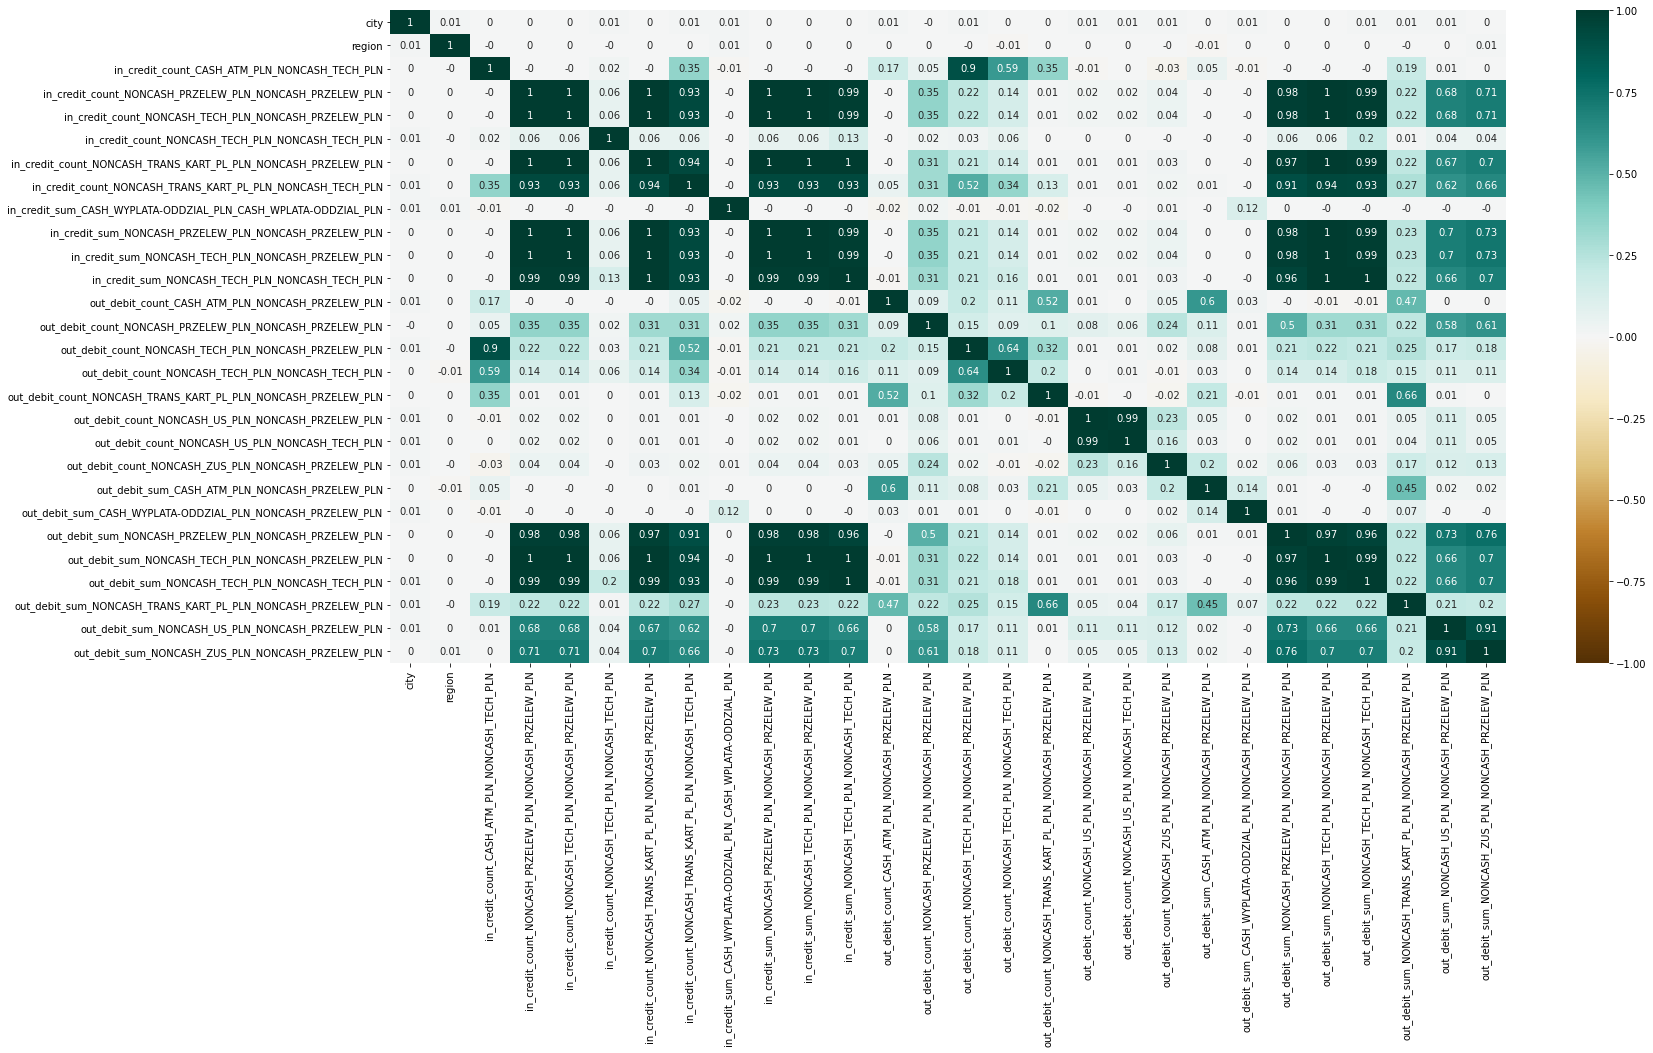

In [216]:
## Choosen variables correlation matrix

plt.figure(figsize=(25, 12))
sns.heatmap(x_pre.corr().round(2),vmin=-1, vmax=1, annot=True,cmap='BrBG')

In [276]:
## Droping of variables correlated together - drop criterion - lower feature importance
Usuwamy zmienn wzajemnie skorelowane - kryterium do usunięcia niższe feature importance z drzewa decyzyjnego

x_pre.drop(['in_credit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',\
            'in_credit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',\
            'in_credit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',\
            'in_credit_sum_NONCASH_TECH_PLN_NONCASH_TECH_PLN',\
            'out_debit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',\
            'out_debit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',\
            'out_debit_sum_NONCASH_TECH_PLN_NONCASH_TECH_PLN',\
            'in_credit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',\
            'out_debit_count_NONCASH_US_PLN_NONCASH_PRZELEW_PLN'], axis=1, inplace=True)

## Checking of NA

x_pre.isna().sum()

city                                                              0
region                                                            0
in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN                     0
in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN                 0
in_credit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN     0
in_credit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_TECH_PLN        0
in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN    0
in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN                0
out_debit_count_CASH_ATM_PLN_NONCASH_PRZELEW_PLN                  0
out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN           0
out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN              0
out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN                 0
out_debit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN     0
out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN                   0
out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_

In [279]:
## Check of unique transactions number

x_pre.nunique()

city                                                                200
region                                                               16
in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN                       612
in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN                   652
in_credit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN       539
in_credit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_TECH_PLN          616
in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN      865
in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN                13047
out_debit_count_CASH_ATM_PLN_NONCASH_PRZELEW_PLN                    251
out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN             742
out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN                674
out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN                   672
out_debit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN       936
out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN                 

In [280]:
clients_tran_all_fin.head()

,is_individual_flag,city,region,in_credit_count_CASH_ATM_EUR_CASH_CDM_PLN,in_credit_count_CASH_ATM_EUR_CASH_UZNANIE_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_EUR,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_GBP,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_USD,in_credit_count_CASH_ATM_EUR_NONCASH_BLIK-mobile_PLN,...,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE_STALE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE_STALE_PLN
0,1,181,3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,51,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,183,12,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,162,14,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,118,6,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [281]:
X =x_pre.values
y = clients_tran_all_fin.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 322)
print(pd.Series(y).value_counts())

1    14993
0     1858
dtype: int64


In [283]:
## Data preprocessing - scaling

scaler = RobustScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
svc = SVC()
svc.fit(X_train_sc, y_train)

SVC()

In [810]:
rf = RandomForestRegressor(n_estimators=200, 
                           max_depth=25,
                           min_samples_split=2,
                           bootstrap=True, 
                           max_features = 'auto') 
rf.fit(X_train_sc, y_train)

RandomForestRegressor(max_depth=25, n_estimators=200)

In [285]:
train = xgb.DMatrix(X_train_sc, label = y_train)
test = xgb.DMatrix(X_test_sc, label = y_test)
param={'max_depth':25, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}
evallist = [(train, 'train'), (test, 'validation')]

In [ ]:
results = dict()

xgbm = xgb.train(param, # parameters dictionary
                 train, # training data set
                 200, # how many trees
                 evallist,  # watchlist
                 evals_result = results,
                 early_stopping_rounds= 10 # stop if there is not improvement
                ) 

In [287]:
train_data=lgb.Dataset(X_train_sc,label=y_train)
param = {'num_leaves':200, 'objective':'binary','max_depth':25,'learning_rate':.05,'max_bin':100, 'force_col_wise':'true'}
param['metric'] = ['auc', 'binary_logloss']

In [ ]:
num_round=400
lgbm=lgb.train(param,train_data,num_round, feature_name=[x for x in x_pre.columns])

In [811]:
## Models benchmark - sampling -> unbalanced

pred_svc=svc.predict(X_test_sc)
pred_rf=rf.predict(X_test_sc)
pred_lgbm=lgbm.predict(X_test_sc)
pred_xgbm=xgbm.predict(test)

print("AUC&ROC RF:", metrics.roc_auc_score(y_test, pred_rf))
print("AUC&ROC SVC:", metrics.roc_auc_score(y_test, pred_svc))
print("AUC&ROC LGBM:", metrics.roc_auc_score(y_test, pred_lgbm))
print("AUC&ROC XGBM:", metrics.roc_auc_score(y_test, pred_xgbm))

AUC&ROC RF: 0.9561120035865057
AUC&ROC SVC: 0.6106866664176037
AUC&ROC LGBM: 0.9601533604811897
AUC&ROC XGBM: 0.9600823775544515


In [812]:
print(metrics.classification_report(y_test, np.round(pred_rf)))
metrics.confusion_matrix(y_test, np.round(pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       355
           1       0.97      0.98      0.98      3016

    accuracy                           0.96      3371
   macro avg       0.90      0.85      0.87      3371
weighted avg       0.95      0.96      0.95      3371



array([[ 255,  100],
       [  51, 2965]])

In [808]:
print(metrics.classification_report(y_test, np.round(pred_lgbm)))
metrics.confusion_matrix(y_test, np.round(pred_lgbm))

              precision    recall  f1-score   support

           0       0.85      0.73      0.78       355
           1       0.97      0.98      0.98      3016

    accuracy                           0.96      3371
   macro avg       0.91      0.86      0.88      3371
weighted avg       0.96      0.96      0.96      3371



array([[ 259,   96],
       [  46, 2970]])

In [809]:
print(metrics.classification_report(y_test, np.round(pred_xgbm)))
metrics.confusion_matrix(y_test, np.round(pred_xgbm))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       355
           1       0.97      0.98      0.98      3016

    accuracy                           0.96      3371
   macro avg       0.90      0.85      0.87      3371
weighted avg       0.95      0.96      0.95      3371



array([[ 255,  100],
       [  51, 2965]])

In [293]:
print(metrics.classification_report(y_test, np.round(pred_svc)))
metrics.confusion_matrix(y_test, np.round(pred_svc))

              precision    recall  f1-score   support

           0       0.87      0.23      0.36       355
           1       0.92      1.00      0.95      3016

    accuracy                           0.91      3371
   macro avg       0.89      0.61      0.66      3371
weighted avg       0.91      0.91      0.89      3371



array([[  80,  275],
       [  12, 3004]])

In [294]:
## Undersampling 

undersample = resample(X_train[y_train == 1],
                       n_samples = len(y_train[y_train == 0]))

In [295]:
X_train_und = np.concatenate([undersample, X_train[y_train == 0]])
y_train_und = np.append(np.ones(len(y_train[y_train == 0])),
                          np.zeros(len(y_train[y_train == 0])))

In [296]:
print(pd.Series(y_train_und).value_counts())

0.0    1503
1.0    1503
dtype: int64


In [297]:
scaler = RobustScaler().fit(X_train_und)
X_train_und_sc = scaler.transform(X_train_und)
X_test_und_sc = scaler.transform(X_test)

svc_und = SVC()
svc_und.fit(X_train_und_sc, y_train_und)

SVC()

In [298]:
rf_und = RandomForestRegressor(n_estimators=30, 
                           max_depth=15,
                           min_samples_split=2,
                           bootstrap=True, 
                           max_features = 'auto') 
rf_und.fit(X_train_und_sc, y_train_und)

RandomForestRegressor(max_depth=15, n_estimators=30)

In [299]:
train_und = xgb.DMatrix(X_train_und_sc, label = y_train_und)
test_und = xgb.DMatrix(X_test_und_sc, label = y_test)
param={'max_depth':15, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.03}
evallist = [(train_und, 'train'), (test_und, 'validation')]

In [ ]:
results = dict()

xgbm_und = xgb.train(param, # parameter dictionary
                 train_und, # training data set
                 30, # how many trees
                 evallist,  # watchlist
                 evals_result = results,
                 early_stopping_rounds= 10 # stop if there is no improvement
                ) 

In [301]:
train_data_und=lgb.Dataset(X_train_und_sc,label=y_train_und)
param = {'num_leaves':30, 'objective':'binary','max_depth':15,'learning_rate':.03,'max_bin':100}
param['metric'] = ['auc', 'binary_logloss']

In [ ]:
num_round=400
lgbm_und=lgb.train(param,train_data_und,num_round, feature_name=[x for x in x_pre.columns])

In [303]:
## Models benchmark - sampling -> undersampling

pred_svc_und=svc_und.predict(X_test_und_sc)
pred_rf_und=rf_und.predict(X_test_und_sc)
pred_lgbm_und=lgbm_und.predict(X_test_und_sc)
pred_xgbm_und=xgbm_und.predict(test_und)

print("AUC&ROC RF:", metrics.roc_auc_score(y_test, pred_rf_und))
print("AUC&ROC SVC:", metrics.roc_auc_score(y_test, pred_svc_und))
print("AUC&ROC XGBM:", metrics.roc_auc_score(y_test, pred_xgbm_und))
print("AUC&ROC LGBM:", metrics.roc_auc_score(y_test, pred_lgbm_und))

AUC&ROC RF: 0.9497982590503232
AUC&ROC SVC: 0.5471728247468899
AUC&ROC XGBM: 0.9490291216796802
AUC&ROC LGBM: 0.9598918444353122


In [304]:
print(metrics.classification_report(y_test, np.round(pred_rf_und)))
metrics.confusion_matrix(y_test, np.round(pred_rf_und))

              precision    recall  f1-score   support

           0       0.50      0.88      0.64       355
           1       0.98      0.90      0.94      3016

    accuracy                           0.90      3371
   macro avg       0.74      0.89      0.79      3371
weighted avg       0.93      0.90      0.91      3371



array([[ 313,   42],
       [ 311, 2705]])

In [305]:
print(metrics.classification_report(y_test, np.round(pred_xgbm_und)))
metrics.confusion_matrix(y_test, np.round(pred_xgbm_und))

              precision    recall  f1-score   support

           0       0.49      0.87      0.63       355
           1       0.98      0.89      0.94      3016

    accuracy                           0.89      3371
   macro avg       0.74      0.88      0.78      3371
weighted avg       0.93      0.89      0.90      3371



array([[ 308,   47],
       [ 320, 2696]])

In [306]:
print(metrics.classification_report(y_test, np.round(pred_lgbm_und)))
metrics.confusion_matrix(y_test, np.round(pred_lgbm_und))

              precision    recall  f1-score   support

           0       0.56      0.88      0.68       355
           1       0.98      0.92      0.95      3016

    accuracy                           0.91      3371
   macro avg       0.77      0.90      0.82      3371
weighted avg       0.94      0.91      0.92      3371



array([[ 311,   44],
       [ 248, 2768]])

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(lgbm_und, X_test_und_sc, y_test)
plt.show()

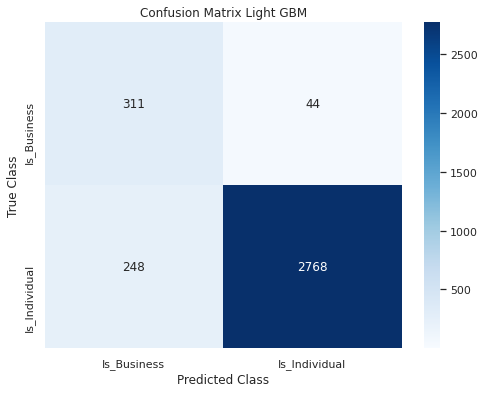

In [757]:
## Confusion Matrix chart

cm = metrics.confusion_matrix(y_test, np.round(pred_lgbm_und))
labels = ['Is_Business', 'Is_Individual']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2)
plt.title('Confusion Matrix Light GBM')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

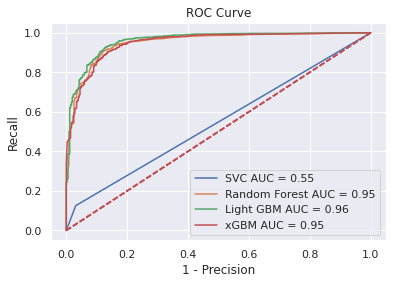

In [747]:
## Models benchmark - ROC chart

def plot_roc(y_test, prob, model_name = ""):
    
    fpr, recall, tresh = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)

    plt.plot(fpr, recall, label = "{} AUC = {}".format(model_name, auc.round(2)))
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel("1 - Precision")
    plt.ylabel("Recall")
    plt.title("ROC Curve")
    plt.legend()

plot_roc(y_test, pred_svc_und, model_name = "SVC")
plot_roc(y_test, pred_rf_und, model_name = "Random Forest")
plot_roc(y_test, pred_lgbm_und, model_name = "Light GBM")
plot_roc(y_test, pred_xgbm_und, model_name = "xGBM")

In [307]:
## Oversampling with SMOTE methode: Synthetic Minority Over-sampling Technique

sm = SMOTE(sampling_strategy=1)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [308]:
y_train_sm = pd.DataFrame(y_train_sm)
y_train_sm.columns = ['Class']
y_train_sm['Class'].value_counts()

1    11977
0    11977
Name: Class, dtype: int64

In [ ]:
scaler = RobustScaler().fit(X_train_sm)
X_train_sm_sc = scaler.transform(X_train_sm)
X_test_sm_sc = scaler.transform(X_test)

svc_sm = SVC()
svc_sm.fit(X_train_sm_sc, y_train_sm)

In [ ]:
rf_sm = RandomForestRegressor(n_estimators=200, 
                           max_depth=25,
                           min_samples_split=2,
                           bootstrap=True, 
                           max_features = 'auto') 
rf_sm.fit(X_train_sm_sc, y_train_sm)

In [311]:
train_sm = xgb.DMatrix(X_train_sm_sc, label = y_train_sm)
test_sm = xgb.DMatrix(X_test_sm_sc, label = y_test)
param={'max_depth':25, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}
evallist = [(train_sm, 'train'), (test_sm, 'validation')]

In [ ]:
results = dict()

xgbm_sm = xgb.train(param, # parameter dictionary
                 train_sm, # training data set
                 200, # how many trees
                 evallist,  # watchlist
                 evals_result = results,
                 early_stopping_rounds= 10 # stop if there is no improvement
                ) 

In [313]:
train_data_sm=lgb.Dataset(X_train_sm_sc,label=y_train_sm)
param = {'num_leaves':200, 'objective':'binary','max_depth':25,'learning_rate':.05,'max_bin':100}
param['metric'] = ['auc', 'binary_logloss']

In [ ]:
num_round=400
lgbm_sm=lgb.train(param,train_data_sm,num_round, feature_name=[x for x in x_pre.columns])

In [315]:
## Models benchmark - sampling -> oversampling

pred_svc_sm=svc_sm.predict(X_test_sm_sc)
pred_rf_sm=rf_sm.predict(X_test_sm_sc)
pred_lgbm_sm=lgbm_sm.predict(X_test_sm_sc)
pred_xgbm_sm=xgbm_sm.predict(test_sm)

print("AUC&ROC RF:", metrics.roc_auc_score(y_test, pred_rf_sm))
print("AUC&ROC SVC:", metrics.roc_auc_score(y_test, pred_svc_sm))
print("AUC&ROC XGBM:", metrics.roc_auc_score(y_test, pred_xgbm_sm))
print("AUC&ROC LGBM:", metrics.roc_auc_score(y_test, pred_lgbm_sm))

AUC&ROC RF: 0.9472354018007246
AUC&ROC SVC: 0.5515653603317519
AUC&ROC XGBM: 0.9498150707961296
AUC&ROC LGBM: 0.9598745656965667


In [316]:
print(metrics.classification_report(y_test, np.round(pred_rf_sm)))
metrics.confusion_matrix(y_test, np.round(pred_rf_sm))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74       355
           1       0.97      0.96      0.97      3016

    accuracy                           0.94      3371
   macro avg       0.84      0.86      0.85      3371
weighted avg       0.94      0.94      0.94      3371



array([[ 272,   83],
       [ 113, 2903]])

In [317]:
print(metrics.classification_report(y_test, np.round(pred_xgbm_sm)))
metrics.confusion_matrix(y_test, np.round(pred_xgbm_sm))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       355
           1       0.97      0.95      0.96      3016

    accuracy                           0.94      3371
   macro avg       0.82      0.87      0.84      3371
weighted avg       0.94      0.94      0.94      3371



array([[ 277,   78],
       [ 138, 2878]])

In [318]:
print(metrics.classification_report(y_test, np.round(pred_lgbm_sm)))
metrics.confusion_matrix(y_test, np.round(pred_lgbm_sm))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       355
           1       0.97      0.98      0.97      3016

    accuracy                           0.95      3371
   macro avg       0.88      0.87      0.87      3371
weighted avg       0.95      0.95      0.95      3371



array([[ 268,   87],
       [  72, 2944]])

In [319]:
## Feature importance by local importance method LIME

cats = pd.get_dummies(x_pre, drop_first=True).columns

In [320]:
cats

Index(['city', 'region', 'in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_TECH_PLN',
       'in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN',
       'in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_CASH_ATM_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_sum_CASH_ATM_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_sum_CASH_WYPLATA-ODDZIAL_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_sum_NON

In [321]:
x_pre.columns

Index(['city', 'region', 'in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_TECH_PLN',
       'in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN',
       'in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_CASH_ATM_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_sum_CASH_ATM_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_sum_CASH_WYPLATA-ODDZIAL_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_sum_NON

In [322]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_und_sc, 
                                                   feature_names= x_pre.columns,
                                                   class_names = ['is_individual_flag'],
                                                   categorical_features= cats,
                                                   verbose = True,
                                                   mode = 'regression'
                                                  )

In [323]:
i = 12

expl = explainer.explain_instance(X_test_und_sc[i], lgbm_und.predict, num_features= 15)

Intercept 0.005731411590266633
Prediction_local [0.718342]
Right: 0.9984083823871654


In [324]:
expl.show_in_notebook(show_table=True)

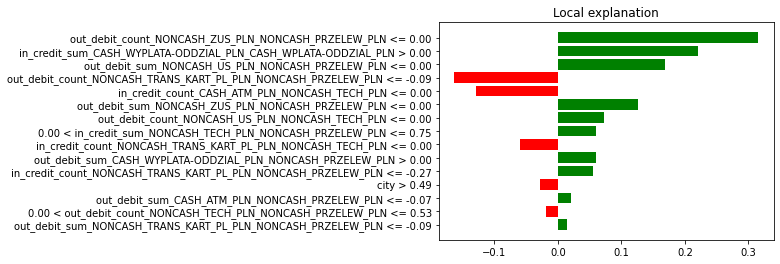

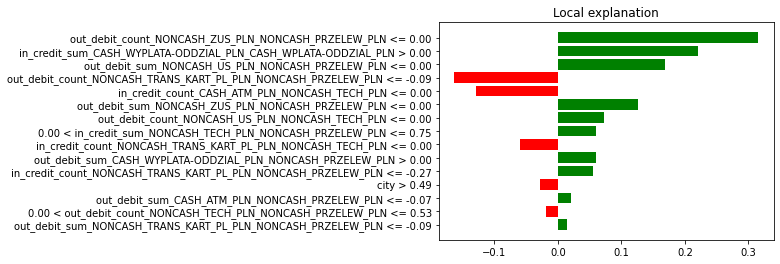

In [325]:
expl.as_pyplot_figure(label=1)

In [756]:
## What are this cities (important variable for business segment forecasting) - when lack of data variable is filled with 0's

x_pre[x_pre["city"]<0.5]

,city,region,in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN,in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN,in_credit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN,in_credit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_TECH_PLN,in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN,in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,out_debit_count_CASH_ATM_PLN_NONCASH_PRZELEW_PLN,out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN,out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN,out_debit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN,out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN,out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN,out_debit_sum_CASH_ATM_PLN_NONCASH_PRZELEW_PLN,out_debit_sum_CASH_WYPLATA-ODDZIAL_PLN_NONCASH_PRZELEW_PLN,out_debit_sum_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN,out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN
157,0,11,12.0,12.0,43.5,12.0,9376.89,36539.130,30.0,48.5,12.0,12.0,323,0,0,11882.32,5000.00,15081.10,0.00,0.00
464,0,10,0.0,0.0,3.0,0.0,0.00,752.630,0.0,29.0,10.0,0.0,7,0,22,0.00,0.00,995.41,20.62,12557.26
579,0,7,1.0,1.0,48.0,1.0,0.00,41778.310,18.0,89.0,7.0,7.0,253,0,4,5373.15,0.00,12223.54,0.00,1285.63
730,0,13,0.0,12.0,0.0,0.0,0.00,221491.205,0.0,119.0,12.0,12.0,0,0,0,0.00,0.00,0.00,0.00,0.00
1202,0,5,0.0,80.0,0.0,0.0,0.00,9026.655,0.0,81.5,80.0,80.0,0,0,0,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15071,0,1,0.0,12.0,0.0,0.0,0.00,1460.310,0.0,0.0,12.0,12.0,0,0,0,0.00,0.00,0.00,0.00,0.00
15302,0,4,6.0,6.0,14.5,6.0,0.00,20894.645,47.0,52.5,32.0,32.0,153,0,0,27124.47,0.00,5150.39,0.00,0.00
15523,0,4,1.0,1.0,0.0,0.0,0.00,28481.440,6.0,1.0,16.0,16.0,0,0,0,531.39,6407.88,0.00,0.00,0.00
15790,0,7,0.0,0.0,9.0,0.0,0.00,3892.890,5.0,23.0,4.0,0.0,39,0,0,2175.52,0.00,6275.38,0.00,0.00


In [328]:
## Feature importance according to Light GBM

feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head(20)

,FeatureImportance
out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN,0.447845
out_debit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN,0.042657
in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN,0.035358
in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.029512
out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,0.023999
out_debit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN,0.018073
out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.017663
city,0.017334
out_debit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.017294
out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN,0.017187


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

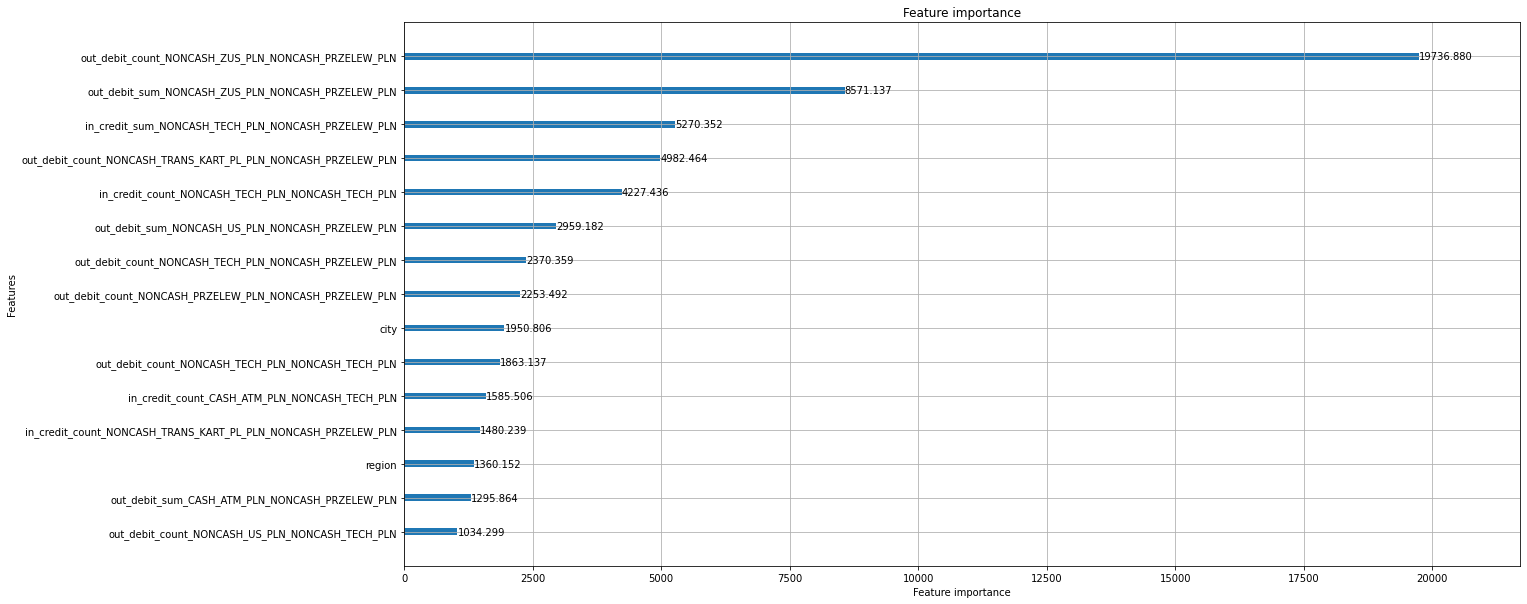

In [327]:
lgb.plot_importance(lgbm_und, max_num_features=15, importance_type='gain', figsize=(20,10))

<AxesSubplot:xlabel='is_individual_flag', ylabel='out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN'>

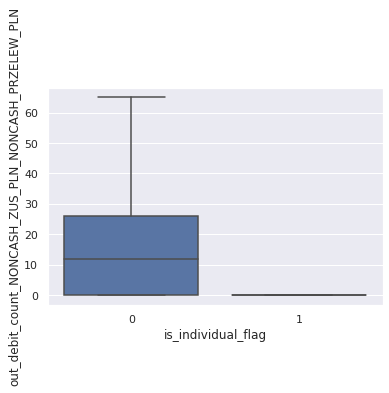

In [329]:
## Chart of distribution of most important variables on target variable - client segment

sns.set(style="darkgrid")
sns.boxplot(x = 'is_individual_flag', y = 'out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1), showfliers=False)

<AxesSubplot:xlabel='is_individual_flag', ylabel='out_debit_sum_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN'>

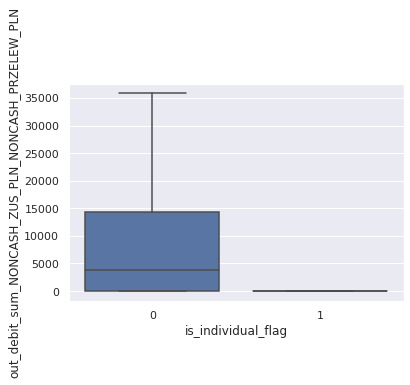

In [330]:
sns.boxplot(x = 'is_individual_flag', y = 'out_debit_sum_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1), showfliers=False)

<AxesSubplot:xlabel='is_individual_flag', ylabel='in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN'>

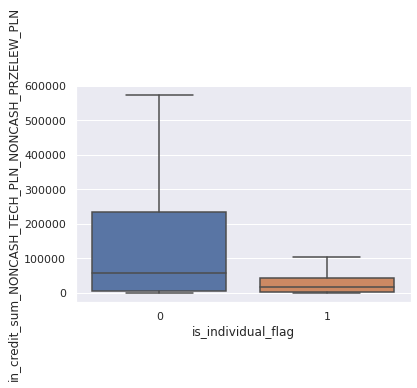

In [331]:
sns.boxplot(x = 'is_individual_flag', y = 'in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1),showfliers=False)

<AxesSubplot:xlabel='is_individual_flag', ylabel='out_debit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN'>

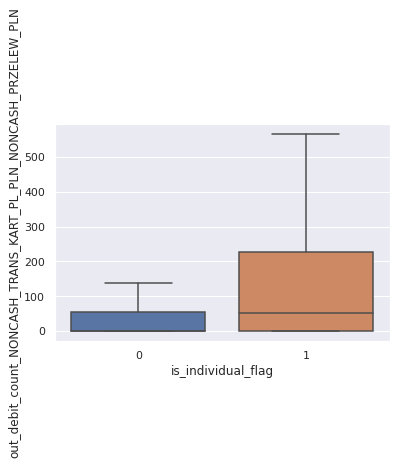

In [751]:
sns.boxplot(x = 'is_individual_flag', y = 'out_debit_count_NONCASH_TRANS_KART_PL_PLN_NONCASH_PRZELEW_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1),showfliers=False)

<AxesSubplot:xlabel='is_individual_flag', ylabel='in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN'>

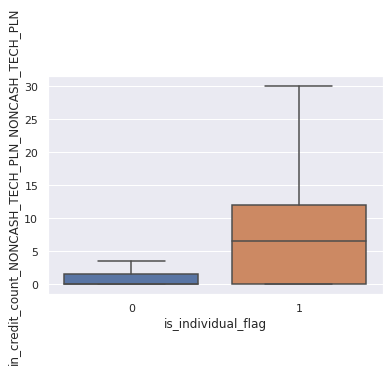

In [752]:
sns.boxplot(x = 'is_individual_flag', y = 'in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1),showfliers=False)

<AxesSubplot:xlabel='is_individual_flag', ylabel='out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN'>

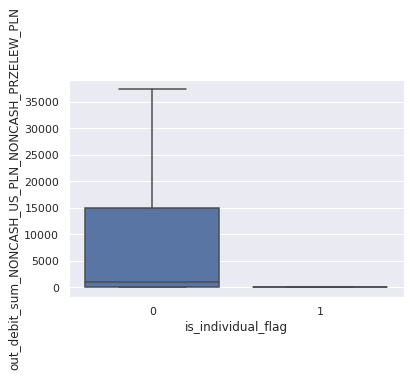

In [750]:
sns.boxplot(x = 'is_individual_flag', y = 'out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1),showfliers=False)

In [ ]:
## Scoring on new data

In [813]:
clients_tst_tran_out=pd.merge(clients_test,tran_agg_out,left_on='cst_id',right_on='out_debit_cst_id',how='left')
clients_tst_tran_out.head()

,cst_id,main_id,city,region,out_debit_cst_id,out_credit_cst_id,out_trans_type,out_trans_category,out_credit_curr,out_debit_curr,out_credit_amt_curr_count,out_credit_amt_curr_sum,out_debit_amt_curr_count,out_debit_amt_curr_sum
0,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,62314880.0,-1.0,CASH,ATM,PLN,PLN,12.0,3235.55,12.0,3235.55
1,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,62314880.0,-1.0,NONCASH,FEE,PLN,PLN,1.0,2.50,1.0,2.50
2,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,62314880.0,-1.0,NONCASH,PRZELEW,PLN,PLN,4.0,898.16,4.0,898.16
3,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,62314880.0,-1.0,NONCASH,TECH,PLN,PLN,13.0,1285.25,13.0,1334.25
4,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,62314880.0,-1.0,NONCASH,TRANS-KART-PL,PLN,PLN,34.0,2823.13,34.0,2823.13


In [814]:
clients_tst_tran_out.drop(['out_debit_cst_id', 'out_credit_cst_id'], axis=1, inplace=True)

In [815]:
clients_tst_tran_all=pd.merge(clients_tst_tran_out,tran_agg_in,left_on='cst_id',right_on='in_credit_cst_id',how='left')
clients_tst_tran_all.head()

,cst_id,main_id,city,region,out_trans_type,out_trans_category,out_credit_curr,out_debit_curr,out_credit_amt_curr_count,out_credit_amt_curr_sum,...,in_debit_cst_id,in_credit_cst_id,in_trans_type,in_trans_category,in_credit_curr,in_debit_curr,in_credit_amt_curr_count,in_credit_amt_curr_sum,in_debit_amt_curr_count,in_debit_amt_curr_sum
0,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,CASH,ATM,PLN,PLN,12.0,3235.55,...,-1.0,62314880.0,NONCASH,PRZELEW,PLN,PLN,15.0,14014.29,15.0,14014.29
1,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,NONCASH,FEE,PLN,PLN,1.0,2.50,...,-1.0,62314880.0,NONCASH,PRZELEW,PLN,PLN,15.0,14014.29,15.0,14014.29
2,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,NONCASH,PRZELEW,PLN,PLN,4.0,898.16,...,-1.0,62314880.0,NONCASH,PRZELEW,PLN,PLN,15.0,14014.29,15.0,14014.29
3,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,NONCASH,TECH,PLN,PLN,13.0,1285.25,...,-1.0,62314880.0,NONCASH,PRZELEW,PLN,PLN,15.0,14014.29,15.0,14014.29
4,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,NONCASH,TRANS-KART-PL,PLN,PLN,34.0,2823.13,...,-1.0,62314880.0,NONCASH,PRZELEW,PLN,PLN,15.0,14014.29,15.0,14014.29


In [816]:
clients_tst_tran_all_piv=clients_tst_tran_all.pivot_table(index=["cst_id","main_id", "city", "region"], 
                       columns=["out_trans_type", "out_trans_category", "out_credit_curr", "out_debit_curr", "in_trans_type", "in_trans_category", "in_credit_curr", "in_debit_curr"],
                       fill_value=0,
                       values=np.r_[clients_tst_tran_all.columns[11:13],clients_tst_tran_all.columns[19:21]]
                      )

In [817]:
clients_tst_tran_all_fin = pd.DataFrame(clients_tst_tran_all_piv.to_records())

In [818]:
clients_tst_tran_all_fin.columns = [hdr.replace("('", "").replace("')", "").replace(", ''", "").replace("', '", "_")  \
                     for hdr in clients_tst_tran_all_fin.columns]
clients_tst_tran_all_fin.head()

,cst_id,main_id,city,region,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_CASH_CDM_PLN_PLN,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_CASH_WPLATA-ODDZIAL_EUR_PLN,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_CASH_WPLATA-ODDZIAL_GBP_PLN,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_CASH_WPLATA-ODDZIAL_PLN_PLN,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_NONCASH_BLIK-mobile_PLN_PLN,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_NONCASH_FEE_PLN_PLN,...,out_debit_amt_curr_sum_NONCASH_ZLECENIE-STALE_PLN_PLN_NONCASH_UZNANIE_EUR_EUR,out_debit_amt_curr_sum_NONCASH_ZLECENIE-STALE_PLN_PLN_NONCASH_UZNANIE_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZLECENIE-STALE_PLN_PLN_NONCASH_ZLECENIE-STALE_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_CASH_CDM_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_CASH_WPLATA-ODDZIAL_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_NONCASH_PRZELEW_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_NONCASH_PRZELEW-ODDZIAL_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_NONCASH_TECH_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_NONCASH_UZNANIE_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_NONCASH_ZLECENIE-STALE_PLN_PLN
0,10391383,8235906434,Białogard,Podlaskie,878.69,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12085807,4908307042,Radom,Opolskie,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13319456,4618118193,Ostrów Wielkopolski,Podkarpackie,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13513850,2259929186,Rzeszów,Śląskie,1010.31,0.0,884.67,0.0,0.0,0.0,...,0.0,4297.09,4297.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15331755,5000503106,Zduńska Wola,Lubuskie,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [819]:
clients_tst_tran_all_fin = convert(clients_tst_tran_all_fin) 
clients_tst_tran_all_fin=clients_tst_tran_all_fin.rename(columns=lambda s: s.replace('_amt_curr','').replace('_PLN_PLN',''))
x_tst_pre=pd.concat([pd.DataFrame(clients_tst_tran_all_fin,columns=x_pre.columns),clients_tst_tran_all_fin["main_id"]],axis=1)

x_tst_pre=x_tst_pre.fillna(0)
X_valid = x_tst_pre.iloc[:,:-1].values

In [820]:
scaler = RobustScaler().fit(X_train_und)
X_valid_sc = scaler.transform(X_valid)

In [821]:
predictions = lgbm_und.predict(X_valid_sc)

pred_lgbm = pd.DataFrame({'main_id': x_tst_pre.iloc[:,-1].values, 'is_individual_pred': predictions})

client_tst_pred=pd.merge(clients_test,pred_lgbm,left_on='main_id',right_on='main_id',how='left')

client_tst_pred.to_csv('dspo_clients_test_pred.csv', index=False)